<a href="https://colab.research.google.com/github/anonymouaccount/From-Theory-to-Evaluation-An-Experimental-Survey-on-Explainable-Artificial-Intelligence/blob/main/Graph_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph **Data**

# **GNNExplainer**

In [ ]:
!pip install torch_geometric

In [ ]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.explain import Explainer, GNNExplainer
import numpy as np
import pandas as pd
import networkx as nx
from torch_geometric.utils import from_networkx
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from google.colab import drive
import zipfile
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Unzip the dataset
def unzip_data(zip_path, extract_to='/content'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzipping the dataset
unzip_data('/content/drive/MyDrive/Network.zip')

# Load the dataset
links_df = pd.read_csv('/content/stack_network_links.csv')
nodes_df = pd.read_csv('/content/stack_network_nodes.csv')

# Check the dataset
print(links_df.head())
print(nodes_df.head())

# Normalize the 'nodesize' feature
scaler = MinMaxScaler()
nodes_df['nodesize'] = scaler.fit_transform(nodes_df[['nodesize']])

# Encode 'group' as labels
label_encoder = LabelEncoder()
nodes_df['group'] = label_encoder.fit_transform(nodes_df['group'])

# Create a graph from the dataset
G = nx.Graph()

# Add nodes with multiple features
for _, row in nodes_df.iterrows():
    G.add_node(row['name'],
               features=[row['nodesize']],
               label=row['group'])

# Add edges with weights
for _, row in links_df.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['value'])

# Compute additional node features
degree_centrality = nx.degree_centrality(G)
clustering_coeff = nx.clustering(G)
nodes_degree = dict(G.degree())

# Update node features
for node in G.nodes:
    G.nodes[node]['features'] = [
        G.nodes[node]['features'][0],  # nodesize
        degree_centrality[node],  # Degree centrality
        clustering_coeff[node],  # Clustering coefficient
        nodes_degree[node]  # Node degree
    ]

# Convert the graph to PyTorch Geometric format
data = from_networkx(G)
data.x = torch.tensor(np.array([G.nodes[n]['features'] for n in G.nodes]), dtype=torch.float)
data.y = torch.tensor(np.array([G.nodes[n]['label'] for n in G.nodes]), dtype=torch.long)

# Define GCN Model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the GNN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(in_channels=data.x.size(1), hidden_channels=16, out_channels=len(label_encoder.classes_)).to(device)
data = data.to(device)

# Train the GNN Model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

# Initialize the explainer
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

# Select a node to explain
node_idx = 0  # Explain the first node
explanation = explainer(data.x, data.edge_index, index=node_idx)

# Print available explanations
print(f'Generated explanations in {explanation.available_explanations}')

# Debug edge_mask
print(f"Edge mask values: {explanation.edge_mask}")

# Visualize feature importance
feature_importance_path = 'feature_importance.png'
if data.x.size(1) > 1:
    explanation.visualize_feature_importance(feature_importance_path, top_k=10)
    print(f"Feature importance plot has been saved to '{feature_importance_path}'")
else:
    print("Feature importance visualization skipped: Only one feature available.")

# Visualize the subgraph
subgraph_path = 'subgraph.pdf'
explanation.visualize_graph(subgraph_path)
print(f"Subgraph visualization plot has been saved to '{subgraph_path}'")


In [ ]:
import torch

def evaluate_xai_metrics(model, data, explanation, node_idx):
    edge_mask = explanation.edge_mask  # Edge importance mask from the explainer

    # Calculate the sparsity score
    sparsity_score = torch.sum(edge_mask <= 0.5).item() / edge_mask.size(0)  # Ratio of edges with mask <= 0.5

    # Mask edges with importance greater than 0.5
    masked_edge_index = data.edge_index[:, edge_mask > 0.5]  # Keep edges with mask > 0.5

    # Predict with the original data
    model.eval()
    original_pred = model(data.x, data.edge_index)[node_idx]

    # Predict with the masked edges
    masked_pred = model(data.x, masked_edge_index)[node_idx]

    # Calculate fidelity score
    original_class = original_pred.argmax().item()
    masked_class = masked_pred.argmax().item()
    fidelity_score = torch.abs(original_pred[original_class] - masked_pred[original_class]).item()

    # Stability: Measure how stable the predictions are across different perturbations (edge mask variations)
    thresholds = torch.linspace(0.1, 0.9, steps=5)  # Different thresholds for edge masking
    stability_scores = []
    for threshold in thresholds:
        masked_edge_index = data.edge_index[:, edge_mask > threshold]  # Mask edges with importance > threshold
        masked_pred = model(data.x, masked_edge_index)[node_idx]
        stability_scores.append(torch.abs(original_pred[original_class] - masked_pred[original_class]).item())

    # Calculate average stability score
    average_stability = torch.mean(torch.tensor(stability_scores)).item()

    # Robustness: Compare predictions with progressively masked graphs
    masked_edge_index_robust = data.edge_index[:, edge_mask <= 0.5]  # Mask edges with importance <= 0.5
    robust_pred = model(data.x, masked_edge_index_robust)[node_idx]
    robustness_score = torch.abs(original_pred[original_class] - robust_pred[original_class]).item()

    # Output results
    print(f"Sparsity score: {sparsity_score:.4f}")
    print(f"Fidelity score for node {node_idx}: {fidelity_score:.4f}")
    print(f"Average Stability score: {average_stability:.4f}")
    print(f"Robustness score: {robustness_score:.4f}")

    return {
        "Sparsity": sparsity_score,
        "Fidelity": fidelity_score,
        "Stability": average_stability,
        "Robustness": robustness_score
    }

# Call the evaluation function
eval_results = evaluate_xai_metrics(model, data, explanation, node_idx)


Sparsity score: 0.8469
Fidelity score for node 0: 0.4214
Average Stability score: 0.4185
Robustness score: 0.4069


# **GraphLIME**

In [ ]:
!pip install --upgrade torch_geometric torch_sparse torch_scatter torch_spline_conv

In [ ]:
!pip install graphlime

In [ ]:
!pip install --upgrade torch-geometric
!pip install --upgrade graphlime

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 0, Loss: 2.6718
Epoch 10, Loss: 2.2520
Epoch 20, Loss: 2.1446
Epoch 30, Loss: 2.0894
Epoch 40, Loss: 2.0410
Epoch 50, Loss: 1.9931
Epoch 60, Loss: 1.9434
Epoch 70, Loss: 1.8936
Epoch 80, Loss: 1.8450
Epoch 90, Loss: 1.7981
Explanation for node 0:
[0.         0.         0.         0.01585176]


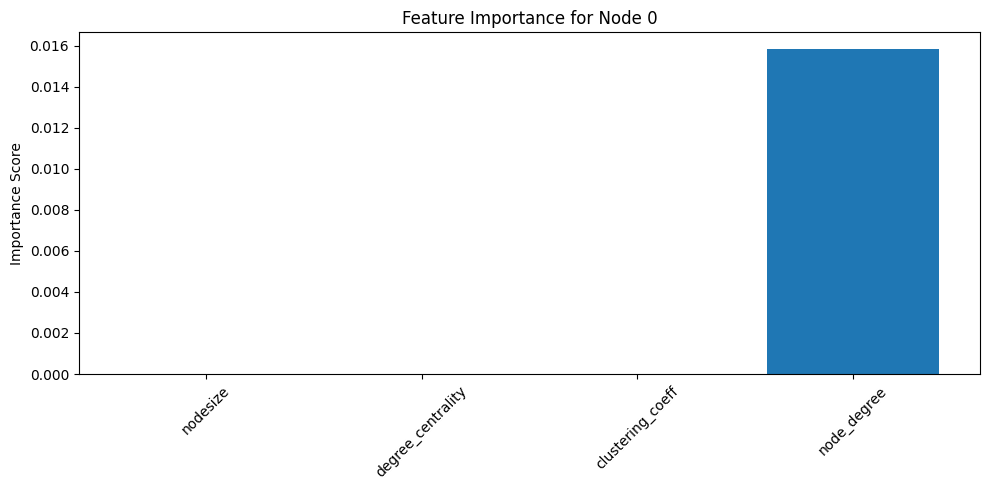


Node information:
Name: html
Group: 6
Features: [0.41222638 0.05263158 0.8666667  6.        ]


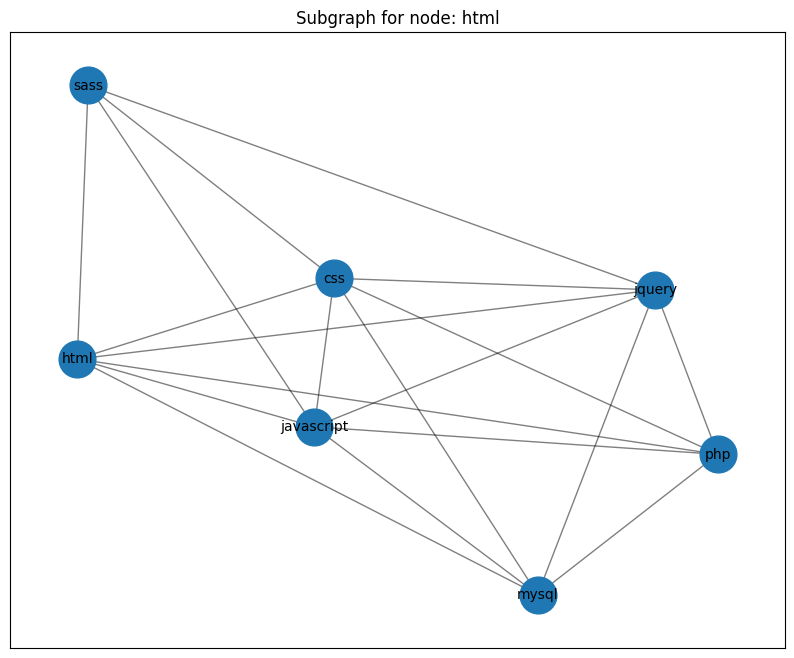

Subgraph visualization plot has been saved to 'subgraph.pdf'


In [ ]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import numpy as np
import pandas as pd
import networkx as nx
from torch_geometric.utils import from_networkx
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LassoLars
from google.colab import drive
import zipfile
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Unzip the dataset
def unzip_data(zip_path, extract_to='/content'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzipping the dataset
unzip_data('/content/drive/MyDrive/Network.zip')

# Load the dataset
links_df = pd.read_csv('/content/stack_network_links.csv')
nodes_df = pd.read_csv('/content/stack_network_nodes.csv')

# Normalize the 'nodesize' feature
scaler = MinMaxScaler()
nodes_df['nodesize'] = scaler.fit_transform(nodes_df[['nodesize']])

# Encode 'group' as labels
label_encoder = LabelEncoder()
nodes_df['group'] = label_encoder.fit_transform(nodes_df['group'])

# Create a graph from the dataset
G = nx.Graph()

# Add nodes with multiple features
for _, row in nodes_df.iterrows():
    G.add_node(row['name'],
               features=[row['nodesize']],
               label=row['group'])

# Add edges with weights
for _, row in links_df.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['value'])

# Compute additional node features
degree_centrality = nx.degree_centrality(G)
clustering_coeff = nx.clustering(G)
nodes_degree = dict(G.degree())

# Update node features
for node in G.nodes:
    G.nodes[node]['features'] = [
        G.nodes[node]['features'][0],  # nodesize
        degree_centrality[node],      # Degree centrality
        clustering_coeff[node],       # Clustering coefficient
        nodes_degree[node]            # Node degree
    ]

# Convert the graph to PyTorch Geometric format
data = from_networkx(G)
data.x = torch.tensor(np.array([G.nodes[n]['features'] for n in G.nodes]), dtype=torch.float)
data.y = torch.tensor(np.array([G.nodes[n]['label'] for n in G.nodes]), dtype=torch.long)

# Define GCN Model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, **kwargs):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the GNN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(in_channels=data.x.size(1), hidden_channels=16, out_channels=len(label_encoder.classes_)).to(device)
data = data.to(device)

# Train the GNN Model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

# GraphLIME Implementation
class GraphLIMEExplainer:
    def __init__(self, model, rho=0.1):
        self.model = model
        self.rho = rho

    def explain_node(self, node_idx, x, edge_index, labels=None):
        device = next(self.model.parameters()).device

        # Convert to numpy if they're tensors
        if torch.is_tensor(x):
            x = x.detach().cpu().numpy()
        if torch.is_tensor(edge_index):
            edge_index = edge_index.detach().cpu().numpy()

        # Get model predictions
        with torch.no_grad():
            log_probs = self.model(
                torch.FloatTensor(x).to(device),
                torch.LongTensor(edge_index).to(device)
            )
            probs = torch.exp(log_probs).cpu().numpy()

        # Get the predicted class
        pred_class = np.argmax(probs[node_idx])

        # Create perturbed samples
        n_features = x.shape[1]
        n_samples = 1000
        perturbed = np.random.normal(
            loc=x[node_idx],
            scale=0.1,
            size=(n_samples, n_features)
        )

        # Get predictions for perturbed samples
        with torch.no_grad():
            edge_index_repeated = np.tile(edge_index, (1, n_samples))
            perturbed_probs = torch.exp(self.model(
                torch.FloatTensor(perturbed).to(device),
                torch.LongTensor(edge_index_repeated).to(device)
            ))[:, pred_class].cpu().numpy()

        # Compute weights
        distances = np.sqrt(((perturbed - x[node_idx])**2).sum(axis=1))
        weights = np.sqrt(np.exp(-(distances**2)/0.1))

        # Solve Lasso regression with current scikit-learn API
        solver = LassoLars(alpha=self.rho, fit_intercept=False, positive=True)
        solver.fit(perturbed * weights[:, None], perturbed_probs * weights)

        return solver.coef_

# Initialize explainer
graphlime_explainer = GraphLIMEExplainer(model)

# Select a node to explain
node_idx = 0  # Explain the first node

# Get explanation
explanation = graphlime_explainer.explain_node(
    node_idx=node_idx,
    x=data.x,
    edge_index=data.edge_index,
    labels=data.y
)

# Print explanation
print(f"Explanation for node {node_idx}:")
print(explanation)

# Visualize feature importance
if len(explanation) > 1:
    plt.figure(figsize=(10, 5))
    features = ['nodesize', 'degree_centrality', 'clustering_coeff', 'node_degree']
    plt.bar(features, explanation)
    plt.title(f'Feature Importance for Node {node_idx}')
    plt.ylabel('Importance Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()
else:
    print("Only one feature available, skipping visualization.")

# Print node information for context
print("\nNode information:")
print(f"Name: {nodes_df.iloc[node_idx]['name']}")
print(f"Group: {label_encoder.inverse_transform([nodes_df.iloc[node_idx]['group']])[0]}")
print(f"Features: {data.x[node_idx].cpu().numpy()}")

# Visualize the subgraph
def visualize_subgraph(G, node_idx, filename='subgraph.pdf'):
    node_name = nodes_df.iloc[node_idx]['name']

    # Get the 1-hop neighborhood
    neighbors = list(G.neighbors(node_name))
    subgraph = G.subgraph([node_name] + neighbors)

    # Draw the subgraph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(subgraph)
    nx.draw_networkx_nodes(subgraph, pos, node_size=700)
    nx.draw_networkx_edges(subgraph, pos, width=1.0, alpha=0.5)
    nx.draw_networkx_labels(subgraph, pos, font_size=10)
    plt.title(f'Subgraph for node: {node_name}')
    plt.savefig(filename)
    plt.show()

visualize_subgraph(G, node_idx, 'subgraph.pdf')
print("Subgraph visualization plot has been saved to 'subgraph.pdf'")


In [ ]:
import torch

def evaluate_xai_metrics(model, data, explanation, node_idx):
    """
    Evaluates XAI metrics for GraphLIME explanations
    """
    # Convert explanation to tensor
    feature_mask = torch.from_numpy(explanation).float().to(data.x.device)

    ### (1) Sparsity: Fraction of features with importance <= 0.5 (already in [0, 1])
    sparsity_score = (feature_mask <= 0.5).sum().item() / feature_mask.size(0)

    ### (2) Fidelity: Change in predicted class probability when unimportant features are masked
    model.eval()
    with torch.no_grad():
        # Get probabilities (softmax of logits)
        original_probs = torch.exp(model(data.x, data.edge_index)[node_idx])  # [n_classes]
        original_class = original_probs.argmax().item()
        original_prob = original_probs[original_class].item()

        # Mask unimportant features (importance <= 0.5)
        masked_x = data.x.clone()
        masked_x[:, feature_mask <= 0.5] = 0
        masked_probs = torch.exp(model(masked_x, data.edge_index)[node_idx])
        masked_prob = masked_probs[original_class].item()

        # Fidelity = 1 - |original_prob - masked_prob|
        fidelity_score = 1.0 - abs(original_prob - masked_prob)

    ### (3) Stability: Consistency under feature perturbations
    stability_scores = []
    thresholds = torch.linspace(0.1, 0.9, steps=5)  # Different masking thresholds

    for threshold in thresholds:
        perturbed_x = data.x.clone()
        perturbed_x[:, feature_mask <= threshold] = 0
        perturbed_probs = torch.exp(model(perturbed_x, data.edge_index)[node_idx])
        perturbed_prob = perturbed_probs[original_class].item()
        stability_scores.append(1.0 - abs(original_prob - perturbed_prob))

    average_stability = torch.mean(torch.tensor(stability_scores)).item()

    ### (4) Robustness: Prediction change when ONLY important features are kept
    robust_x = data.x.clone()
    robust_x[:, feature_mask <= 0.5] = 0  # Keep only important features
    robust_probs = torch.exp(model(robust_x, data.edge_index)[node_idx])
    robust_prob = robust_probs[original_class].item()
    robustness_score = 1.0 - abs(original_prob - robust_prob)

    ### Results
    print(f"[GraphLIME Metrics]")
    print(f"  Sparsity : {sparsity_score:.4f}")
    print(f"  Fidelity : {fidelity_score:.4f}")
    print(f"  Stability : {average_stability:.4f}")
    print(f"  Robustness : {robustness_score:.4f}")

    return {
        "Sparsity": sparsity_score,
        "Fidelity": fidelity_score,
        "Stability": average_stability,
        "Robustness": robustness_score
    }

# Usage
eval_results = evaluate_xai_metrics(model, data, explanation, node_idx)


[GraphLIME Metrics]
  Sparsity : 1.0000
  Fidelity : 0.5262
  Stability : 0.5262
  Robustness : 0.5262


# **XGNN**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 0, Loss: 2.7144
Epoch 10, Loss: 2.1895
Epoch 20, Loss: 2.1120
Epoch 30, Loss: 2.0580
Epoch 40, Loss: 2.0033
Epoch 50, Loss: 1.9460
Epoch 60, Loss: 1.8864
Epoch 70, Loss: 1.8241
Epoch 80, Loss: 1.7587
Epoch 90, Loss: 1.6930


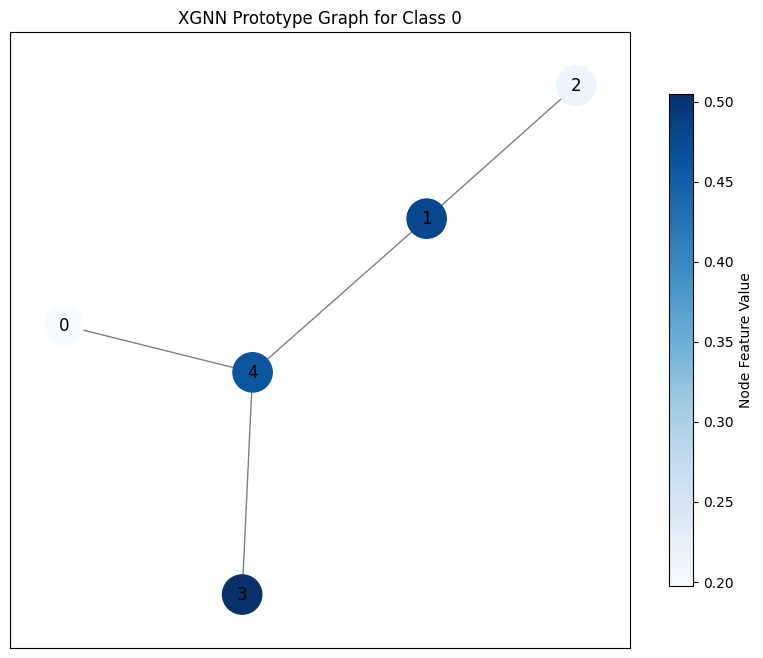


XGNN Prototype Graph Information:
Number of nodes: 5
Number of edges: 4
Average degree: 1.60

Node Features (first 3 nodes):
Node 0: [ 0.197  -0.0322  0.3316  0.8628]
Node 1: [ 0.4778  0.0663 -0.0083 -1.5717]
Node 2: [0.2124 0.0715 0.6035 5.977 ]


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import numpy as np
import pandas as pd
import networkx as nx
from torch_geometric.utils import from_networkx, to_networkx
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from google.colab import drive
import zipfile
import matplotlib.pyplot as plt
import itertools
import random
from torch.distributions import Bernoulli

# Mount Google Drive
drive.mount('/content/drive')

# Unzip the dataset
def unzip_data(zip_path, extract_to='/content'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Unzipping the dataset
unzip_data('/content/drive/MyDrive/Network.zip')

# Load the dataset
links_df = pd.read_csv('/content/stack_network_links.csv')
nodes_df = pd.read_csv('/content/stack_network_nodes.csv')

# Normalize the 'nodesize' feature
scaler = MinMaxScaler()
nodes_df['nodesize'] = scaler.fit_transform(nodes_df[['nodesize']])

# Encode 'group' as labels
label_encoder = LabelEncoder()
nodes_df['group'] = label_encoder.fit_transform(nodes_df['group'])

# Create a graph from the dataset
G = nx.Graph()

# Add nodes with multiple features
for _, row in nodes_df.iterrows():
    G.add_node(row['name'],
               features=[row['nodesize']],
               label=row['group'])

# Add edges with weights
for _, row in links_df.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['value'])

# Compute additional node features
degree_centrality = nx.degree_centrality(G)
clustering_coeff = nx.clustering(G)
nodes_degree = dict(G.degree())

# Update node features
for node in G.nodes:
    G.nodes[node]['features'] = [
        G.nodes[node]['features'][0],  # nodesize
        degree_centrality[node],      # Degree centrality
        clustering_coeff[node],       # Clustering coefficient
        nodes_degree[node]            # Node degree
    ]

# Convert the graph to PyTorch Geometric format
data = from_networkx(G)
data.x = torch.tensor(np.array([G.nodes[n]['features'] for n in G.nodes]), dtype=torch.float)
data.y = torch.tensor(np.array([G.nodes[n]['label'] for n in G.nodes]), dtype=torch.long)

# Define GCN Model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, **kwargs):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the GNN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(in_channels=data.x.size(1), hidden_channels=16, out_channels=len(label_encoder.classes_)).to(device)
data = data.to(device)

# Train the GNN Model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

# Improved XGNN Implementation
class XGNNExplainer:
    def __init__(self, model, num_nodes=5, num_generations=30, population_size=20):
        self.model = model
        self.num_nodes = num_nodes
        self.num_generations = num_generations
        self.population_size = population_size
        self.device = next(model.parameters()).device

        # Compute statistics from original graph
        self.feat_mean = data.x.mean(dim=0)
        self.feat_std = data.x.std(dim=0)
        self.original_density = 2 * G.number_of_edges() / (G.number_of_nodes() * (G.number_of_nodes() - 1))

    def generate_prototype_graph(self, target_class):
        # Initialize population
        population = []
        for _ in range(self.population_size):
            graph = nx.Graph()
            # Initialize nodes with features sampled from learned distribution
            for i in range(self.num_nodes):
                features = torch.randn(data.x.size(1), device=self.device) * self.feat_std + self.feat_mean
                graph.add_node(i, features=features)

            # Connect nodes with probability matching original graph
            for i, j in itertools.combinations(range(self.num_nodes), 2):
                if torch.rand(1, device=self.device).item() < self.original_density:
                    graph.add_edge(i, j)
            population.append(graph)

        # Evolutionary optimization
        for generation in range(self.num_generations):
            fitness_scores = []

            # Evaluate each graph
            for graph in population:
                pyg_graph = from_networkx(graph)
                pyg_graph.x = torch.stack([graph.nodes[i]['features'] for i in graph.nodes()]).to(self.device)
                pyg_graph.edge_index = pyg_graph.edge_index.to(self.device) if pyg_graph.edge_index.size(1) > 0 else \
                    torch.empty((2, 0), dtype=torch.long, device=self.device)

                with torch.no_grad():
                    log_probs = self.model(pyg_graph.x, pyg_graph.edge_index)
                    target_score = torch.exp(log_probs)[:, target_class].mean()
                    other_score = torch.exp(log_probs)[:, [c for c in range(log_probs.size(1)) if c != target_class]].mean()
                    fitness_scores.append((target_score - other_score).item())

            # Selection
            top_indices = np.argpartition(fitness_scores, -self.population_size//2)[-self.population_size//2:]
            top_graphs = [population[i] for i in top_indices]
            new_population = top_graphs.copy()

            # Reproduction
            while len(new_population) < self.population_size:
                # Tournament selection
                parent1, parent2 = random.sample(top_graphs, 2)

                # Crossover
                child = nx.Graph()
                for i in range(self.num_nodes):
                    # Random feature inheritance
                    if random.random() < 0.5:
                        child.add_node(i, features=parent1.nodes[i]['features'].clone())
                    else:
                        child.add_node(i, features=parent2.nodes[i]['features'].clone())

                # Edge inheritance
                for i, j in set(parent1.edges()).union(set(parent2.edges())):
                    if random.random() < 0.5:
                        child.add_edge(i, j)

                # Adaptive mutation
                mutation_rate = max(0.1, 0.5 * (1 - generation/self.num_generations))
                if random.random() < mutation_rate:
                    # Edge mutation
                    if child.edges() and random.random() < 0.5:
                        child.remove_edge(*random.choice(list(child.edges())))
                    else:
                        i, j = random.sample(range(self.num_nodes), 2)
                        child.add_edge(i, j)

                    # Feature mutation
                    node_idx = random.randint(0, self.num_nodes-1)
                    mutation = torch.randn(data.x.size(1), device=self.device) * self.feat_std * 0.1
                    child.nodes[node_idx]['features'] += mutation

                new_population.append(child)

            population = new_population

        # Return best graph
        best_idx = np.argmax(fitness_scores)
        return population[best_idx]

# Initialize XGNN explainer
xgnn_explainer = XGNNExplainer(model, num_nodes=5, num_generations=20, population_size=20)

# Generate prototype graph for target class
target_class = 0  # Explain class 0
prototype_graph = xgnn_explainer.generate_prototype_graph(target_class)

# Visualize the prototype graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(prototype_graph)
node_colors = [prototype_graph.nodes[i]['features'][0].item() for i in prototype_graph.nodes()]

# Create a plot with proper axes
ax = plt.gca()
nodes = nx.draw_networkx_nodes(prototype_graph, pos, node_color=node_colors,
                             cmap=plt.cm.Blues, node_size=800, ax=ax)
nx.draw_networkx_edges(prototype_graph, pos, edge_color='gray', ax=ax)
nx.draw_networkx_labels(prototype_graph, pos, font_size=12, ax=ax)

# Add colorbar with proper mappable
sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues,
                          norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.set_label('Node Feature Value')

plt.title(f'XGNN Prototype Graph for Class {target_class}')
plt.savefig('xgnn_prototype.png')
plt.show()

# Print prototype graph info
print("\nXGNN Prototype Graph Information:")
print(f"Number of nodes: {prototype_graph.number_of_nodes()}")
print(f"Number of edges: {prototype_graph.number_of_edges()}")
print(f"Average degree: {sum(dict(prototype_graph.degree()).values()) / prototype_graph.number_of_nodes():.2f}")
print("\nNode Features (first 3 nodes):")
for i in range(min(3, prototype_graph.number_of_nodes())):
    print(f"Node {i}: {prototype_graph.nodes[i]['features'].cpu().numpy().round(4)}")


In [ ]:
def evaluate_xgnn_core_metrics(model, data, prototype_graph, target_class):
    """
    Evaluates XGNN prototype:

    Args:
        model: Trained GNN model
        data: Original graph data
        prototype_graph: Generated prototype graph
        target_class: Target class being explained
    Returns:
        Dictionary of core metrics (Sparsity, Fidelity, Stability, Robustness)
    """
    # Convert prototype to PyG format
    pyg_proto = from_networkx(prototype_graph)
    pyg_proto.x = torch.stack([prototype_graph.nodes[i]['features']
                             for i in prototype_graph.nodes()]).to(data.x.device)
    pyg_proto.edge_index = pyg_proto.edge_index.to(data.x.device)

    with torch.no_grad():
        # Get prototype predictions
        proto_probs = torch.exp(model(pyg_proto.x, pyg_proto.edge_index))

        # Get original class nodes' predictions
        class_mask = (data.y == target_class)
        original_probs = torch.exp(model(data.x, data.edge_index))[class_mask]

    ### (1) Sparsity (Graph complexity)
    n = prototype_graph.number_of_nodes()
    max_edges = n * (n - 1) / 2
    sparsity = 1 - (prototype_graph.number_of_edges() / max(max_edges, 1))

    ### (2) Fidelity (Representation quality)
    fidelity_diff = proto_probs[:, target_class].mean().item() - original_probs[:, target_class].mean().item()
    fidelity = 1 - abs(fidelity_diff)  # Normalized to [0,1]

    ### (3) Stability (Multiple runs consistency)
    stability_runs = []
    for _ in range(3):  # 3 different random seeds
        temp_proto = xgnn_explainer.generate_prototype_graph(target_class)
        temp_features = torch.stack([temp_proto.nodes[i]['features'] for i in temp_proto.nodes()]).to(data.x.device)
        temp_edge_index = from_networkx(temp_proto).edge_index.to(data.x.device)
        temp_probs = torch.exp(model(temp_features, temp_edge_index))[:, target_class].mean().item()
        stability_runs.append(temp_probs)
    stability = 1 - (max(stability_runs) - min(stability_runs))  # Closer to 1 = more stable

    ### (4) Robustness (Noise resistance)
    noisy_proto = prototype_graph.copy()
    for i in noisy_proto.nodes():
        noisy_proto.nodes[i]['features'] += torch.randn_like(noisy_proto.nodes[i]['features']) * 0.1
    noisy_features = torch.stack([noisy_proto.nodes[i]['features'] for i in noisy_proto.nodes()]).to(data.x.device)
    noisy_edge_index = from_networkx(noisy_proto).edge_index.to(data.x.device)
    robust_probs = torch.exp(model(noisy_features, noisy_edge_index))[:, target_class].mean().item()
    robustness = 1 - abs(proto_probs[:, target_class].mean().item() - robust_probs)

    ### Results
    print(f"\nXGNN Core Metrics for Class {target_class}:")
    print(f"  Sparsity:    {sparsity:.4f} ")
    print(f"  Fidelity:    {fidelity:.4f} ")
    print(f"  Stability:   {stability:.4f} ")
    print(f"  Robustness:  {robustness:.4f} ")

    return {
        "Sparsity": sparsity,
        "Fidelity": fidelity,
        "Stability": stability,
        "Robustness": robustness
    }

# Usage
target_class = 0
prototype = xgnn_explainer.generate_prototype_graph(target_class)
metrics = evaluate_xgnn_core_metrics(model, data, prototype, target_class)



XGNN Core Metrics for Class 0:
  Sparsity:    0.7000 
  Fidelity:    0.7335 
  Stability:   0.7725 
  Robustness:  0.9633 
